In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
EPS = 1e-5

## Runge-Kutta methods for SDE

In [3]:
def fmap(fs, x):
    return np.array([f(*x) for f in fs])

In [4]:
def runge_kutta4_system(fs, x, y0):
    h = x[1] - x[0]
    y = np.ndarray((len(x), len(y0)))
    y[0] = y0
    for i in range(1, len(x)):
        k1 = h * fmap(fs, [x[i - 1], *y[i - 1]])
        k2 = h * fmap(fs, [x[i - 1] + h/2, *(y[i - 1] + k1/2)])
        k3 = h * fmap(fs, [x[i - 1] + h/2, *(y[i - 1] + k2/2)])
        k4 = h * fmap(fs, [x[i - 1] + h, *(y[i - 1] + k3)])
        y[i] = y[i - 1] + (k1 + 2*k2 + 2*k3 + k4) / 6
    return y

Now let's check if method works correctly. To do so, we are going to use **scipy.integrate.odeint**.

We are going to solve the next problem

$$
\frac{dy}{dt} =  
\begin{pmatrix}
  0 & 1 & 0 & 0 & 0 & 0 \\
  -\frac{c_2 + c_1}{m_1} & 0 & \frac{c_2}{m_1} & 0 & 0 & 0 \\
  0 & 0 & 0 & 1 & 0 & 0 \\
  \frac{c_2}{m_2} & 0 & -\frac{c_3 + c_2}{m_2} & 0 & \frac{c_3}{m_2} & 0 \\
  0 & 0 & 0 & 0 & 0 & 1 \\
  0 & 0 & \frac{c_3}{m_3} & 0 & -\frac{c_4 + c_3}{m_3} & 0
 \end{pmatrix}
 y = Ay, \\
 y(t_0) = y_{ans}(t_0)
$$

First we have to generate matrix $A$

In [5]:
def gen_A(c1, m1, m2, c2, c3, c4, m3): # correct
    A = np.zeros((6, 6))
    A[0, 1] = 1
    A[1, 0] =  -(c2 + c1)/m1
    A[1, 2] = c2/m1
    A[2, 3] = 1
    A[3, 0] = c2/m2
    A[3, 2] = -(c3 + c2)/m2
    A[3, 4] = c3/m2
    A[4, 5] = 1
    A[5, 2] = c3/m3
    A[5, 4] = -(c4 + c3)/m3
    return A

Now we need some values to substitute variables $c_1, \dots, m_3$ in matrix $A$.

Let's assume that 
$$
(c_1, c_2, c_3, c_4) = (4, 4, 6, 3), \\
(m_1, m_2, m_3) = (4, 2, 3), \\
t \in [0, 10], \Delta t = 0.1, \\
y(0) = (0, 1, 0, 3, 0, 2)
$$

In [6]:
c1, c2, c3, c4 = 4, 4, 6, 3
m1, m2, m3 = 4, 2, 3
t = np.linspace(0, 10, 101)
y0 = np.array([0, 1, 0, 3, 0, 2])

In [7]:
A = gen_A(c1, m1, m2, c2, c3, c4, m3)
A

array([[ 0.,  1.,  0.,  0.,  0.,  0.],
       [-2.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 2.,  0., -5.,  0.,  3.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  2.,  0., -3.,  0.]])

Then let's write function to evaluate this system using Runge-Kutta method.

In [8]:
def eval_y(A, t, y0): # correct
    fs = []
    for i in range(6):
        fun = (lambda i: lambda *args: np.dot(A[i], np.array(args[1:])))(i)
        fs.append(fun)
    return runge_kutta4_system(fs, t, y0)

To run **scipy.integrate.odeint** we need to use different function for derivatives

In [9]:
def dydt(y, t):
    dy = [None] * 6
    dy[0] = y[1]
    dy[1] = -2 * y[0] + y[2]
    dy[2] = y[3]
    dy[3] = 2 * y[0] -5 * y[2] + 3 * y[4]
    dy[4] = y[5]
    dy[5] = 2 * y[2] - 3 * y[4]
    return dy

Now we can compare results, using **Frobenius** norm
$$
||A||_F = \Big[ \sum_{i,j} \big|a_{i,j}\big|^2 \Big]^{1/2}
$$

In [10]:
ys_rk4 = eval_y(A, t, y0)
ys_sp = odeint(dydt, y0, t)
np.linalg.norm(ys_rk4 - ys_sp)

0.0037790230699419579

As we can check it's pretty small, and if we are going to decrease step $h$ error will go down.

## Runge-Kutta methods for matrices

We are going to solve next problem
$$
\frac{dU(t)}{dt} = \frac{\partial (Ay)}{\partial y^T} U(t) + \frac{\partial (Ay)}{\partial \beta^T}(t), \\
U(t_0) = 0,
$$
In our case we have
$$
\frac{\partial (Ay)}{\partial y^T} = A
$$
Let's denote
$$
B(t) = \frac{\partial (Ay)}{\partial \beta^T}
$$
Finally we have
$$
\frac{dU(t)}{dt} = A \cdot U(t) + B(t), \\
U(t_0) = 0,
$$

**NOTE! We can compute $B(t)$ only in some points. So we are going to compress our variable $t$ twice to use RK4.**

In [11]:
def eval_U(A, Bs, t):
    h = t[1] - t[0]
    q, m, n = Bs.shape
    Us = np.empty((q // 2 + q % 2, m, n))
    for i in range(n):
        fs = []
        for j in range(m):
            fun = (lambda i, j: lambda *args: Bs[int(round(args[0] / h)), j, i] + np.dot(A[j], np.array(args[1:])))(i, j)
            fs.append(fun)
        x = t[::2]
        y0 = np.zeros(m)
        Us[:, :, i] = runge_kutta4_system(fs, x, y0)
    return Us

We need function to generate $B(t)$

$$
B(t) = \frac{\partial}{\partial \beta^T} 
\begin{pmatrix}
  0 & 1 & 0 & 0 & 0 & 0 \\
  -\frac{c_2 + c_1}{m_1} & 0 & \frac{c_2}{m_1} & 0 & 0 & 0 \\
  0 & 0 & 0 & 1 & 0 & 0 \\
  \frac{c_2}{m_2} & 0 & -\frac{c_3 + c_2}{m_2} & 0 & \frac{c_3}{m_2} & 0 \\
  0 & 0 & 0 & 0 & 0 & 1 \\
  0 & 0 & \frac{c_3}{m_3} & 0 & -\frac{c_4 + c_3}{m_3} & 0
 \end{pmatrix}
 y
= \frac{\partial}{\partial \beta^T} 
\begin{pmatrix}
  y_2 \\
  -\frac{c_2 + c_1}{m_1} y_1 + \frac{c_2}{m_1} y_3 \\
  y_4 \\
  \frac{c_2}{m_2} y_1 - \frac{c_3 + c_2}{m_2} y_3 + \frac{c_3}{m_2} y_5 \\
  y_6 \\
  \frac{c_3}{m_3} y_3 - \frac{c_4 + c_3}{m_3} y_5
\end{pmatrix} = \\
=\begin{pmatrix}
  0 & 0 & 0 \\
  -\frac{1}{m_1} y_1 & \frac{c_2 + c_1}{m_1^2} y_1 - \frac{c_2}{m_1^2} y_3 & 0 \\
  0 & 0 & 0 \\
  0 & 0 & -\frac{c_2}{m_2^2} y_1 + \frac{c_3 + c_2}{m_2^2} y_3 - \frac{c_3}{m_2^2} y_5 \\
  0 & 0 & 0 \\
  0 & 0 & 0
\end{pmatrix}
$$

In [12]:
def gen_Bs(ys, c1, m1, m2, c2, c3, c4, m3): # correct
    q = ys.shape[0]
    Bs = np.zeros((q, 6, 3))
    Bs[:, 1, 0] = -1/m1 * ys[:, 0]
    Bs[:, 1, 1] = (c2 + c1)/m1**2 * ys[:, 0] - c2/m1**2 * ys[:, 2]
    Bs[:, 3, 2] = -c2/m2**2 * ys[:, 0] + (c3 + c2)/m2**2 * ys[:, 2] - c3/m2**2 * ys[:, 4]
    return Bs

## Result evaluation

$$
\Delta \beta = \Big( \int_{t_0}^{t_k} U^T(t)U(t)dt \Big)^{-1} \int_{t_0}^{t_k} U^T(t)(y_{ans}(t) - y(t))dt
$$

In [13]:
def eval_delta(Us, ys, ys_ans): # correct
    q = Us.shape[0]
    T1 = np.zeros((3, 3))
    for i in range(q):
        T1 = T1 + np.dot(Us[i].T, Us[i])
    T2 = np.zeros((3, 1))
    ys = ys[::2]
    ys_ans = ys_ans[::2]
    for i in range(q):
        T2 = T2 + np.dot(Us[i].T, np.reshape(ys_ans[i] - ys[i], (6, 1)))
    return np.dot(np.linalg.inv(T1), T2)

$$
I(\beta) = \int_{t_0}^{t_k} (y_{ans}(t) - y(t))^T(y_{ans}(t) - y(t))dt
$$

In [14]:
def eval_diff(ys, ys_ans): # correct
    q = ys.shape[0]
    ans = 0
    for i in range(q):
        ans = ans + np.dot(ys_ans[i] - ys[i], ys_ans[i] - ys[i])
    return ans

In [15]:
def eval_beta(beta0, other, ys_ans, t):
    beta = beta0
    for i in range(100):
        A = gen_A(*beta, *other)
        ys = eval_y(A, t, y0)
        err = eval_diff(ys, ys_ans)
        print(err)
        if (err < EPS): break
        Bs = gen_Bs(ys, *beta, *other)
        Us = eval_U(A, Bs, t)
        delta = eval_delta(Us, ys, ys_ans)
        beta = beta + delta[:, 0]
    return beta

## Data to process

Here we have
$$
(c_2, c_3, c_4, m_3) = (0.3, 0.2, 0.12, 18), \\
\beta = (c_1, m_1, m_2)^T, \\
\beta_0 = (0.1, 11, 23)^T, \\
t \in [0, 50], \Delta t = 0.2,
$$

In [16]:
ys_ans = np.loadtxt(open('data/y1.txt', 'r')).T
y0 = ys_ans[0]
t = np.linspace(0, 50, 251)
c2, c3, c4, m3 = 0.3, 0.2, 0.12, 18
beta0 = np.array([0.1, 11, 23])

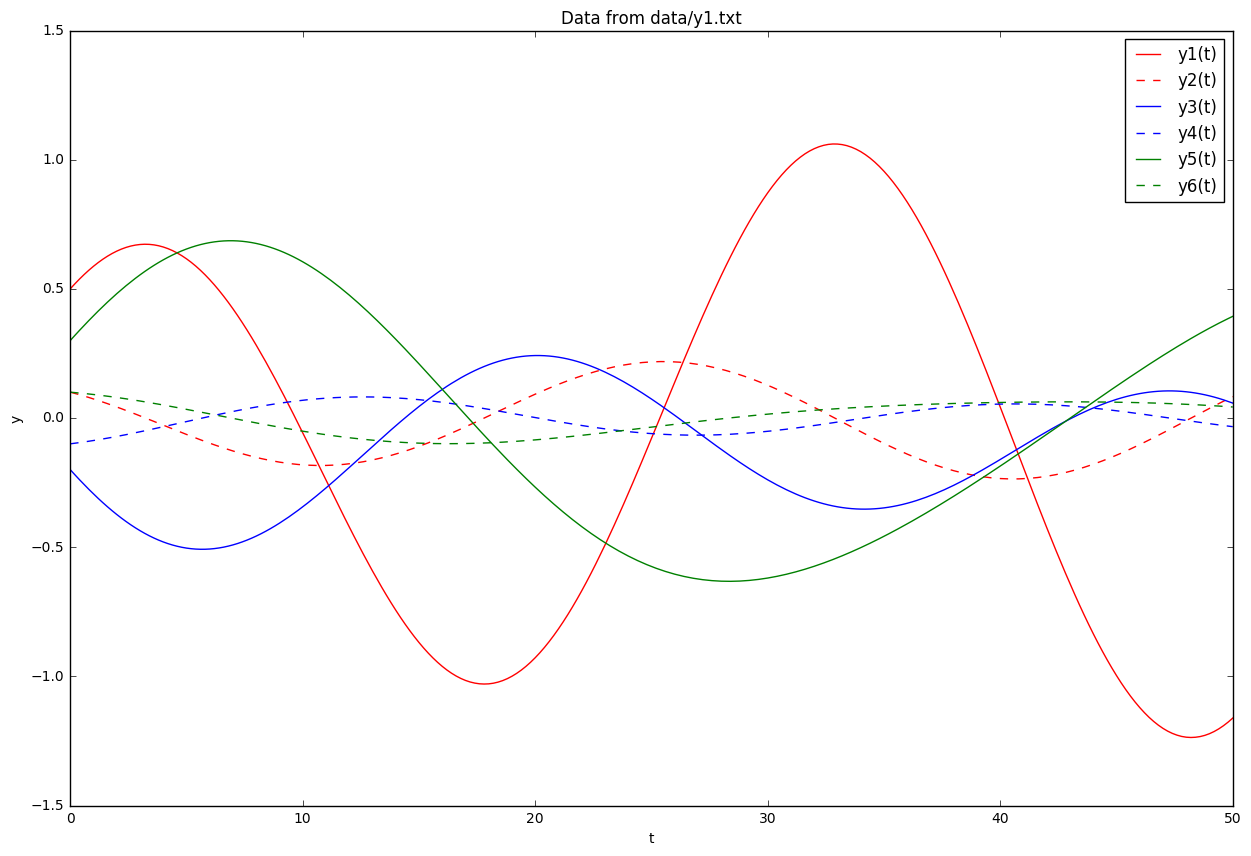

In [17]:
plt.figure(figsize=(15, 10))
plt.plot(t, ys_ans[:, 0], 'r', label='y1(t)')
plt.plot(t, ys_ans[:, 1], 'r--', label='y2(t)')
plt.plot(t, ys_ans[:, 2], 'b', label='y3(t)')
plt.plot(t, ys_ans[:, 3], 'b--', label='y4(t)')
plt.plot(t, ys_ans[:, 4], 'g', label='y5(t)')
plt.plot(t, ys_ans[:, 5], 'g--', label='y6(t)')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Data from data/y1.txt')
plt.legend(loc='best')
plt.show()

In [18]:
beta_res = eval_beta(beta0, [c2, c3, c4, m3], ys_ans, t)
beta_res

16.60283908
0.364971834231
8.58989127105e-06


array([  0.14000668,  11.9996012 ,  27.99681746])

Looks like we have an answer. Let's check this one!

In [19]:
c1, m1, m2 = beta_res
A = gen_A(c1, m1, m2, c2, c3, c4, m3)
ys_gen = eval_y(A, t, y0)

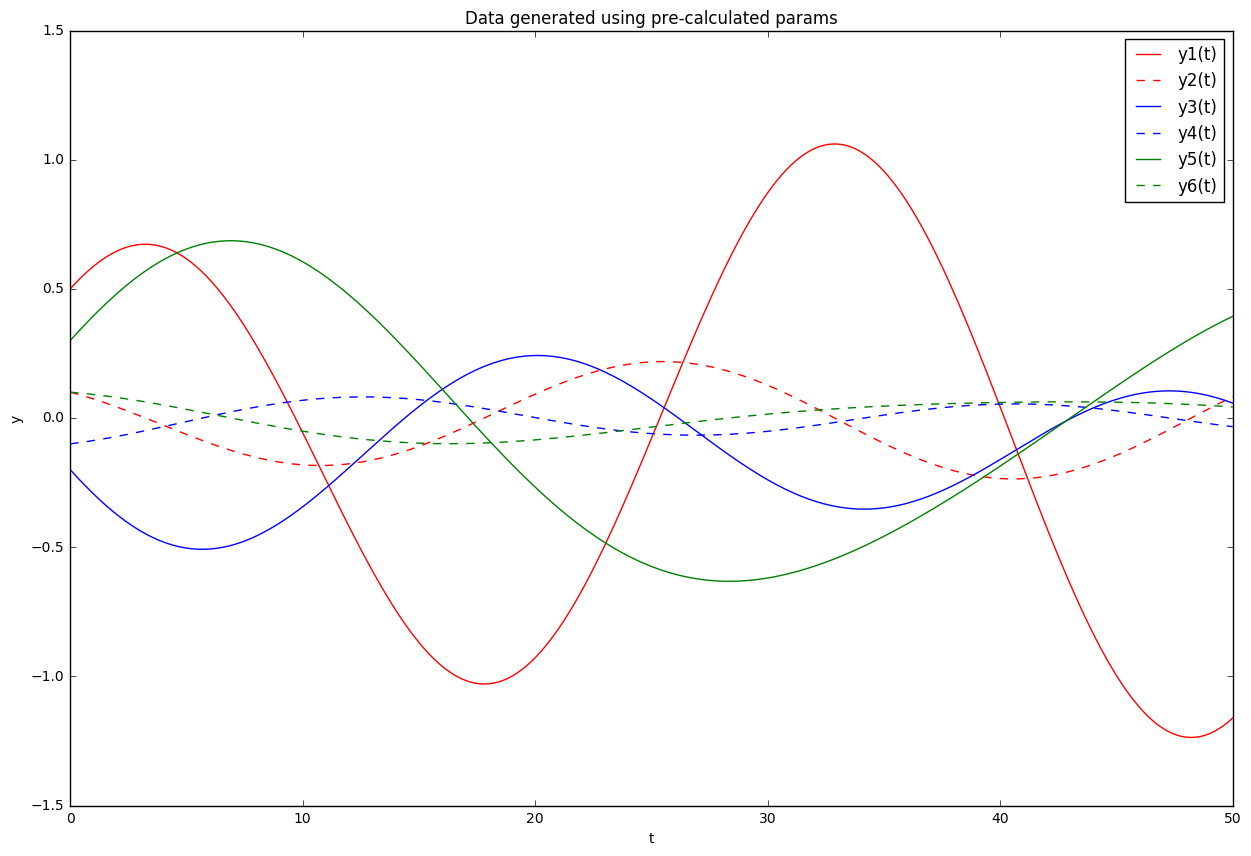

In [20]:
plt.figure(figsize=(15, 10))
plt.plot(t, ys_gen[:, 0], 'r', label='y1(t)')
plt.plot(t, ys_gen[:, 1], 'r--', label='y2(t)')
plt.plot(t, ys_gen[:, 2], 'b', label='y3(t)')
plt.plot(t, ys_gen[:, 3], 'b--', label='y4(t)')
plt.plot(t, ys_gen[:, 4], 'g', label='y5(t)')
plt.plot(t, ys_gen[:, 5], 'g--', label='y6(t)')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Data generated using pre-calculated params')
plt.legend(loc='best')
plt.show()